In [1]:
!python prepare_data.py

args: Namespace(root_dir='.')
Preparing triviaqa validation Qwen: 100%|████| 100/100 [00:00<00:00, 288.11it/s]
Preparing triviaqa validation meta-llama: 100%|█| 100/100 [00:00<00:00, 389.55it
Preparing triviaqa test meta-llama: 100%|████| 100/100 [00:00<00:00, 402.66it/s]
Done!


In [2]:
'''
测试数据准备
'''

import os
import pickle
from tqdm import tqdm
from collections import defaultdict
import argparse
from core.models.entailment import EntailmentDeberta
from core.data.data_utils import load_ds_from_json

def load_pickle_file(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

def save_pickle_file(file_path, data):
    with open(file_path, 'wb') as f:
        pickle.dump(data, f)


In [3]:
result = load_pickle_file("output/result/Qwen/Qwen2.5-7B-Instruct/squad_train.pkl")
print(len(result["id"]))
print(result["data"][result["id"][0]].keys())

2000
dict_keys(['example', 'golden', 'irrelevant', 'without'])


In [4]:
d = result["data"][result["id"][0]]
d.keys()

dict_keys(['example', 'golden', 'irrelevant', 'without'])

In [5]:
d

defaultdict(dict,
            {'example': {'id': '57313c0a497a881900248cae',
              'question': 'How were pigments like red lake created?',
              'context': 'Unlike vermilion or red ochre, made from minerals, red lake pigments are made by mixing organic dyes, made from insects or plants, with white chalk or alum. Red lac was made from the gum lac, the dark red resinous substance secreted by various scale insects, particularly the Laccifer lacca from India. Carmine lake was made from the cochineal insect from Central and South America, Kermes lake came from a different scale insect, kermes vermilio, which thrived on oak trees around the Mediterranean. Other red lakes were made from the rose madder plant and from the brazilwood tree.',
              'answers': ['mixing organic dyes'],
              'irrelevant_id': '57268318708984140094c88b',
              'irrelevant_context': 'One of the paper\'s best known front pages, published on 4 May 1982, commemorated the torpedoin

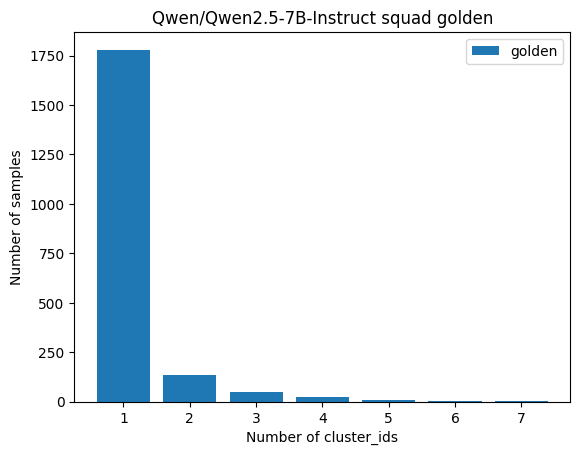

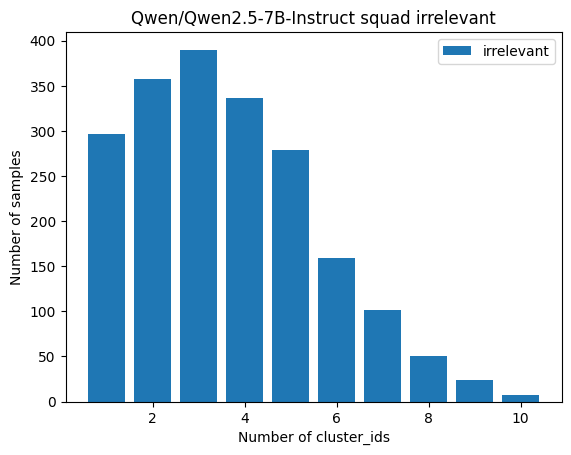

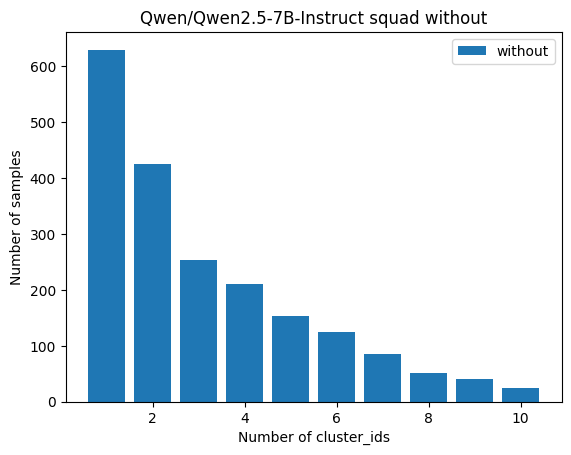

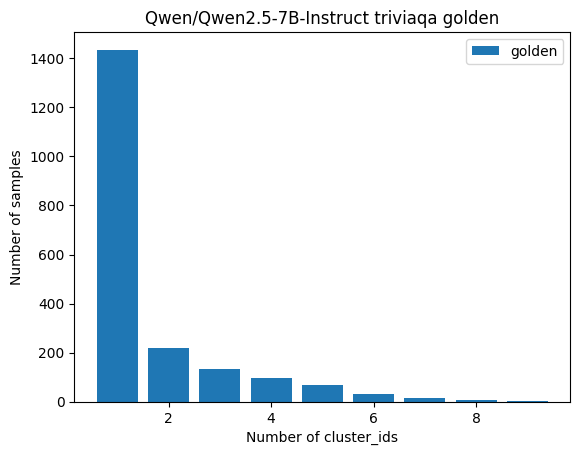

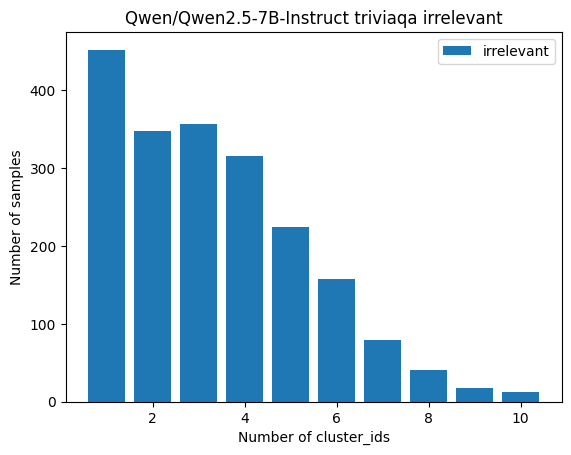

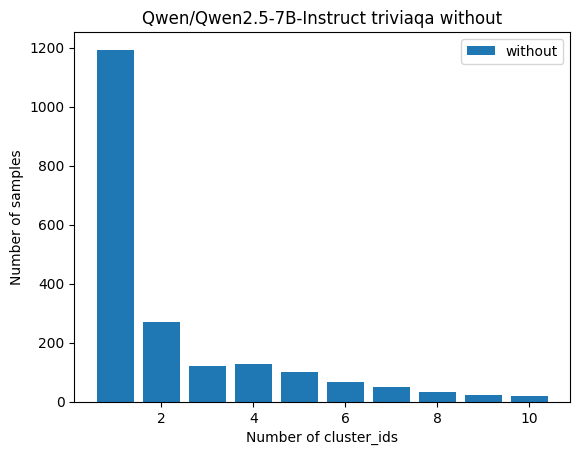

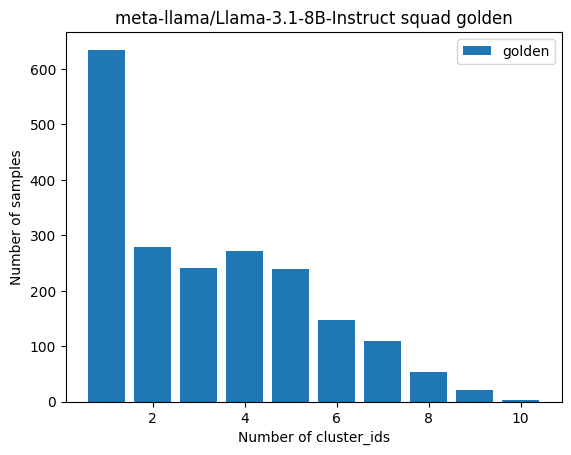

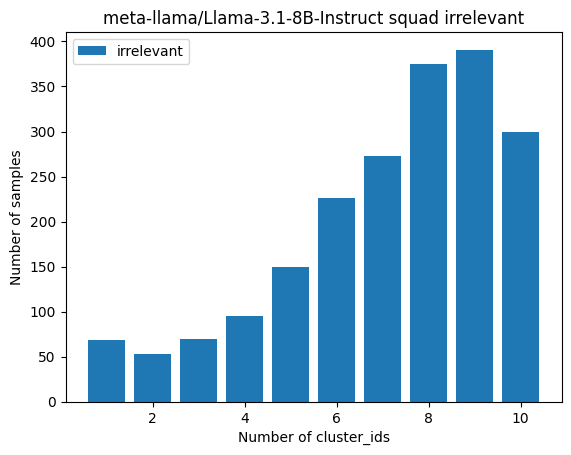

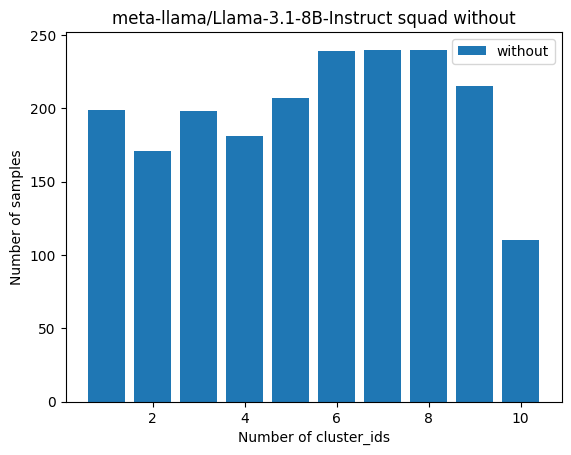

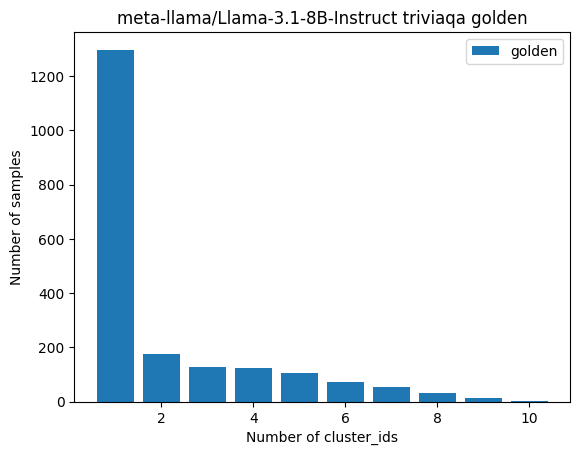

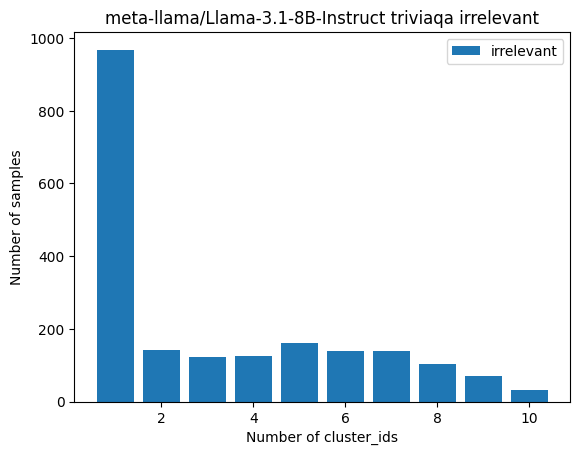

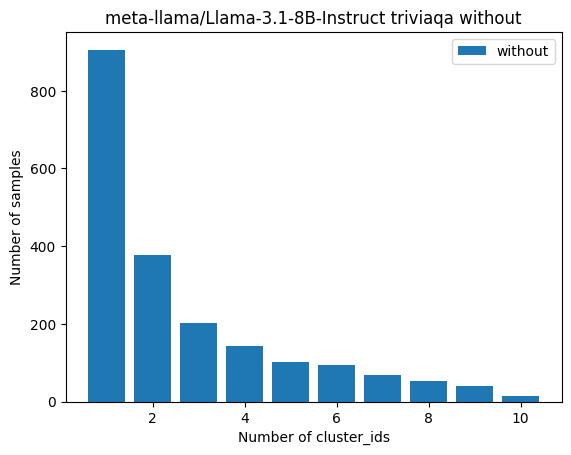

In [6]:
def stat_cluster_ids(result):
    from collections import Counter
    gen_counts = defaultdict(Counter)
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            cluster_ids = data[sample_type]['cluster_ids']
            # 计算cluster_ids中不同元素的个数（聚簇数量）
            num_cluster_ids = len(set(cluster_ids))
            gen_counts[sample_type].update([num_cluster_ids])
    return gen_counts

def visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name):
    # 可视化分布
    import matplotlib.pyplot as plt
    import seaborn as sns
    for sample_type in ['golden', 'irrelevant', 'without']:
        x, y = zip(*sorted(gen_counts[sample_type].items()))
        plt.bar(x, y, label=sample_type)
        plt.legend()
        plt.xlabel('Number of cluster_ids')
        plt.ylabel('Number of samples')
        plt.title(f'{model_name} {dataset_name} {sample_type}')
        plt.show()

model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
dataset_names = ["squad", "triviaqa"]
for model_name in model_names:
    for dataset_name in dataset_names:
        result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_train.pkl")
        gen_counts = stat_cluster_ids(result)
        visualize_cluster_ids_distribution(gen_counts, model_name, dataset_name)

In [8]:
# 统计模型针对数据集的三种不同采样的准确率
def stat_accuracy(result):
    accs = {}
    for data in result["data"].values():
        for sample_type in ['golden', 'irrelevant', 'without']:
            greedy = data[sample_type]['greedy']
            if greedy is None:
                continue
            acc = greedy['accuracy']
            if sample_type not in accs:
                accs[sample_type] = []
            accs[sample_type].append(acc)
    return accs

model_names = ["Qwen/Qwen2.5-7B-Instruct", "meta-llama/Llama-3.1-8B-Instruct"]
dataset_names = ["squad", "triviaqa"]
splits = ["train", "validation", "test"]
for model_name in model_names:
    for dataset_name in dataset_names:
        for split in splits:
            result = load_pickle_file(f"output/result/{model_name}/{dataset_name}_{split}.pkl")
            stat_acc = stat_accuracy(result)
            for sample_type, accs in stat_acc.items():
                print(f"{model_name} {dataset_name} {split} {sample_type} accuracy: {sum(accs) / len(accs)}")


Qwen/Qwen2.5-7B-Instruct squad train golden accuracy: 0.876
Qwen/Qwen2.5-7B-Instruct squad train irrelevant accuracy: 0.1105
Qwen/Qwen2.5-7B-Instruct squad train without accuracy: 0.2595
Qwen/Qwen2.5-7B-Instruct squad validation golden accuracy: 0.88
Qwen/Qwen2.5-7B-Instruct squad validation irrelevant accuracy: 0.14
Qwen/Qwen2.5-7B-Instruct squad validation without accuracy: 0.3
Qwen/Qwen2.5-7B-Instruct squad test golden accuracy: 0.88
Qwen/Qwen2.5-7B-Instruct squad test irrelevant accuracy: 0.21
Qwen/Qwen2.5-7B-Instruct squad test without accuracy: 0.34
Qwen/Qwen2.5-7B-Instruct triviaqa train golden accuracy: 0.8215
Qwen/Qwen2.5-7B-Instruct triviaqa train irrelevant accuracy: 0.4207103551775888
Qwen/Qwen2.5-7B-Instruct triviaqa train without accuracy: 0.619
Qwen/Qwen2.5-7B-Instruct triviaqa validation golden accuracy: 0.82
Qwen/Qwen2.5-7B-Instruct triviaqa validation irrelevant accuracy: 0.45
Qwen/Qwen2.5-7B-Instruct triviaqa validation without accuracy: 0.64
Qwen/Qwen2.5-7B-Instruct